In [12]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearnex import patch_sklearn

patch_sklearn()
# https://github.com/scikit-learn/scikit-learn/issues/24238
# pip install threadpoolctl==3.1.0
from sklearn.manifold import LocallyLinearEmbedding
from typing import Literal

def generate_L_2(n=4):
    return np.eye(n) * n - np.ones((n, n))


def generate_L_3(n=3):
    matrix = np.eye(n) * 2 - np.eye(n, k=1) - np.eye(n, k=-1)
    matrix[0, 0] -= 1
    matrix[-1, -1] -= 1
    return matrix 


def generate_L_4(n=4):
    matrix = np.eye(n) * 2 - np.eye(n, k=1) - np.eye(n, k=-1)
    matrix[0, -1] -= 1
    matrix[-1, 0] -= 1
    return matrix


def generate_L_5(n=4):
    matrix = np.eye(n)
    matrix[0] -= 1
    matrix[:, 0] -= 1
    matrix[0, 0] += n
    return matrix


def generate_L_6(n=2):
    dense_deg_matrix = np.ones((n, n)) * 4
    dense_deg_matrix[0] -= 1
    dense_deg_matrix[:, 0] -= 1
    dense_deg_matrix[-1] -= 1
    dense_deg_matrix[:, -1] -= 1
    adj_matrix = np.zeros((n*n, n*n))
    for i in range(n*n):
        for j in range(i+1, n*n):
            if (j - i) == 1 or (j - i) == n:
                adj_matrix[i, j] = 1
                adj_matrix[j, i] = 1
    laplacian = np.diag(dense_deg_matrix.reshape(n * n)) - adj_matrix
    return laplacian

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [13]:
def convert_L_to_A(L: np.ndarray):
    A = L.copy()
    for i in range(len(L)):
        A[i, i] = 0
    return A


def run_eigh(matrix):
    eigendecomposition = np.linalg.eigh(matrix)
    return eigendecomposition.eigenvalues, eigendecomposition.eigenvectors.T


def apply_diffusion_kernel(L: np.ndarray, t):
    eigenvalues, eigenvectors = run_eigh(L)
    eigenvalues = np.exp(-t * eigenvalues)
    # Take out the smallest eigenvalue of L (np.exp(-t * 0) = 1 -> 0)
    # eigenvalues[0] = 0
    
    L_star = eigenvectors.T @ np.diag(eigenvalues) @ eigenvectors
    return L_star

In [14]:
def draw_single_subplot(fig, ax, G, pos, title, is_representation=False):
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, ax=ax)
    if is_representation:
        ax.set_axis_on()
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        ax.set_xlabel("Axis 1", size=14)
        ax.set_ylabel("Axis 2", size=14)
    ax.set_title(title, size=16)


def draw_graph(G_list, graph_type, method):
    pos_list = [{}, {}, {}]
    for graph_idx, G in enumerate(G_list):
        for node_idx, attr in G.nodes.items(): 
            pos_list[graph_idx][node_idx] = attr["pos"]

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    # Complete graph
    if graph_type in (0, 1):
        n = len(G_list[0].nodes)
        ori_graph = nx.complete_graph(n)
        title = f"({method}) Complete graph with n = {n}"
    # Path graph
    elif graph_type == 2:
        n = len(G_list[0].nodes)
        ori_graph = nx.path_graph(n)
        title = f"Path graph with with n = {n}"
    # Cycle graph
    elif graph_type == 3:
        n = len(G_list[0].nodes)
        ori_graph = nx.cycle_graph(n)
        title = f"Cycle graph with with n = {n}"
    # Star graph
    elif graph_type == 4:
        n = len(G_list[0].nodes) - 1
        ori_graph = nx.star_graph(n)
        title = f"Star graph with with n = {n}"
    # Grid graph
    elif graph_type == 5:
        n = int(np.sqrt(len(G_list[0].nodes)))
        ori_graph = nx.grid_2d_graph(n, n)
        title = f"Grid graph with with n = {n}" 

    pos_layout = nx.spring_layout(ori_graph)
    draw_single_subplot(fig, axes[0, 0], ori_graph, pos_layout, title="Graph layout", is_representation=False)
    draw_single_subplot(fig, axes[0, 1], G_list[0], pos_list[0], title="First two", is_representation=True)
    draw_single_subplot(fig, axes[1, 0], G_list[1], pos_list[1], title="SVD", is_representation=True)
    draw_single_subplot(fig, axes[1, 1], G_list[2], pos_list[2], title="LLE", is_representation=True)
    fig.suptitle(title, size=18)


def plot_results(L_list, method: Literal["Diffusion kernel", "Graph Laplacian"], t=1):
    for idx, L in enumerate(L_list):
        A = convert_L_to_A(L)
        if method == "Diffusion kernel":
            L = apply_diffusion_kernel(L, t=t)
        eigenvalues, eigenvectors = run_eigh(L)
        first_two = eigenvectors[1:3, :]
        svd = eigenvectors[-2:, :]
        full_rank_representations = eigenvectors[1:].T 
        lle_transformed = LocallyLinearEmbedding(n_components=2, n_neighbors=2).fit_transform(full_rank_representations)
        G_list = [nx.from_numpy_array(A) for _ in range(3)]
        for i in range(len(G_list[0].nodes)):
            G_list[0].nodes[i]["pos"] = [first_two[0, i], first_two[1, i]]
            G_list[1].nodes[i]["pos"] = [svd[1, i], svd[0, i]]
            G_list[2].nodes[i]["pos"] = [lle_transformed[i, 0], lle_transformed[i, 1]]
        draw_graph(G_list, idx, method)

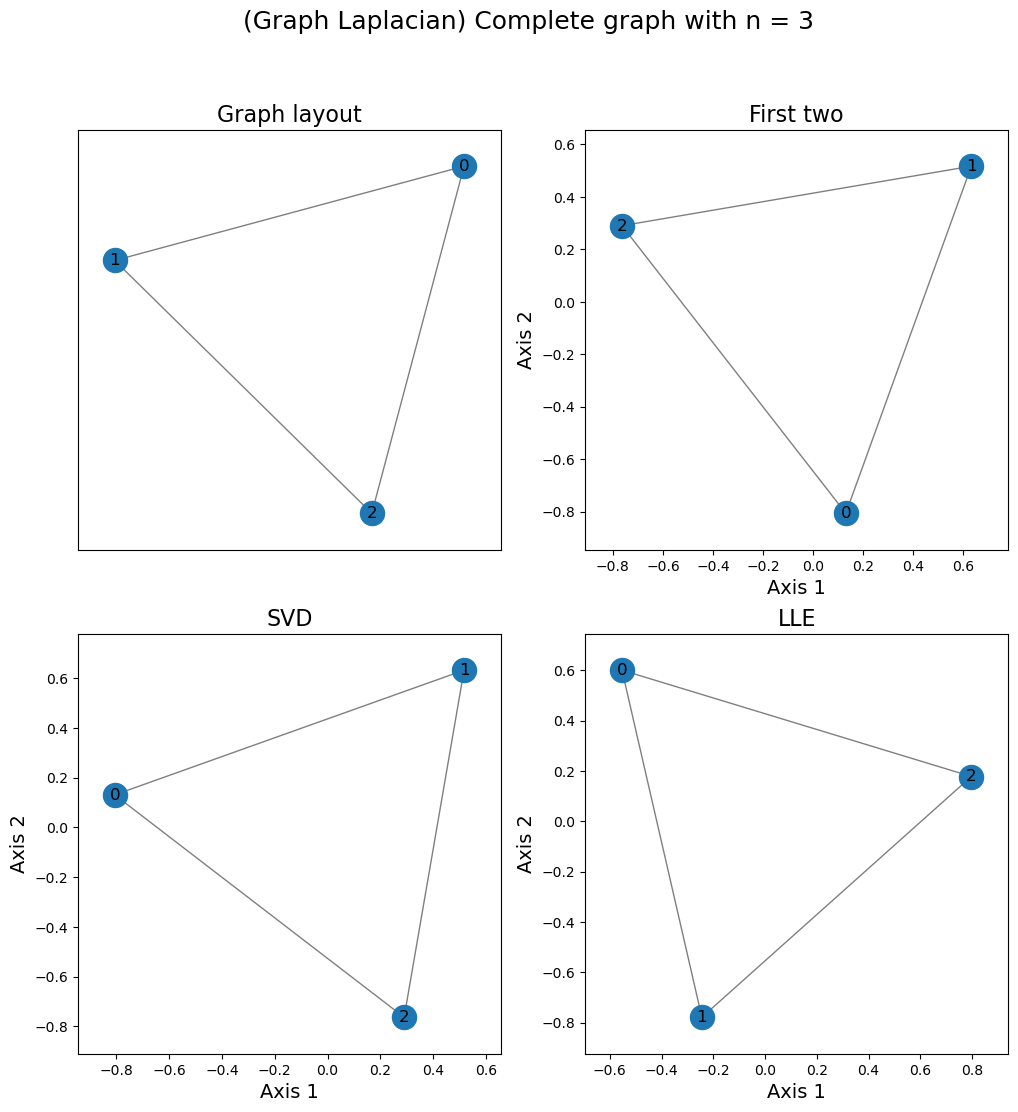

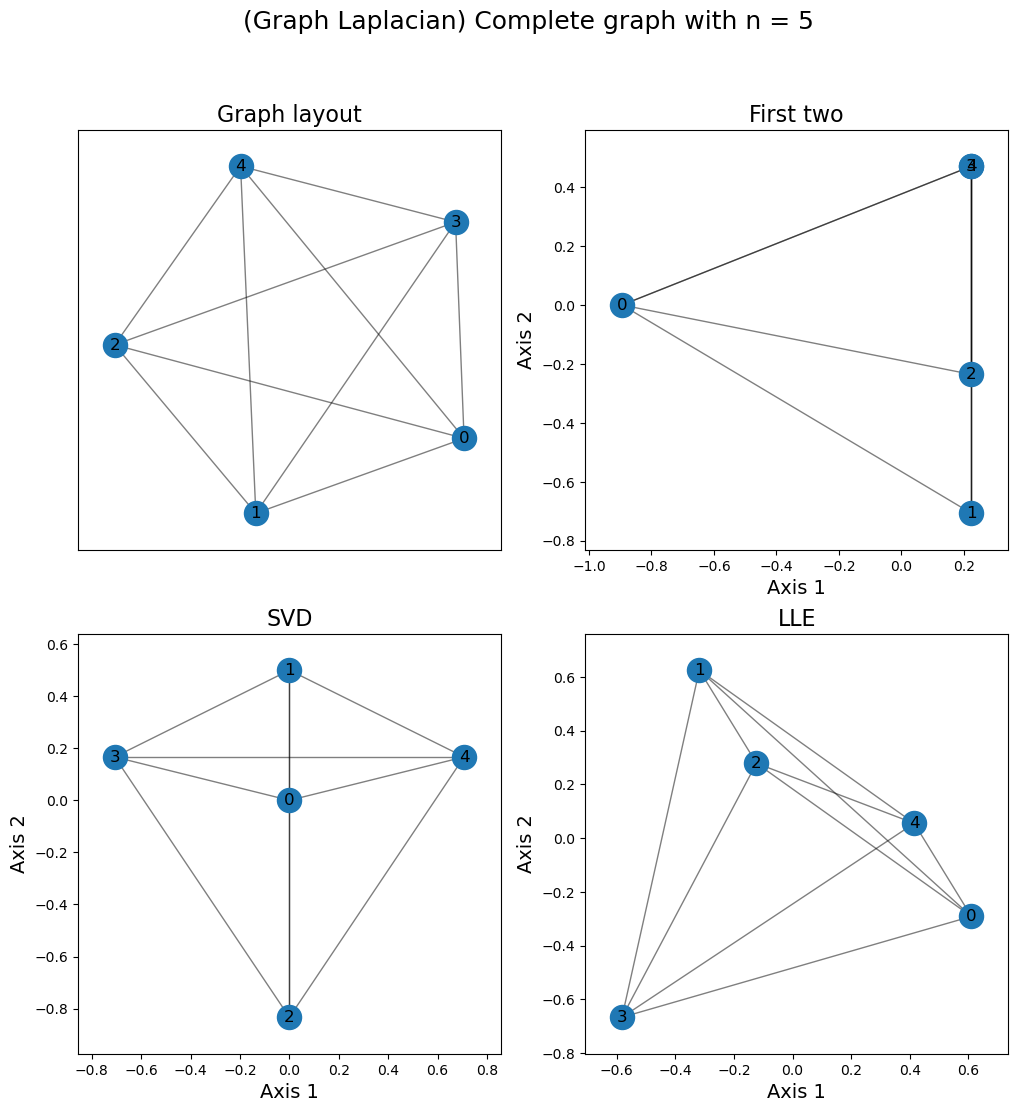

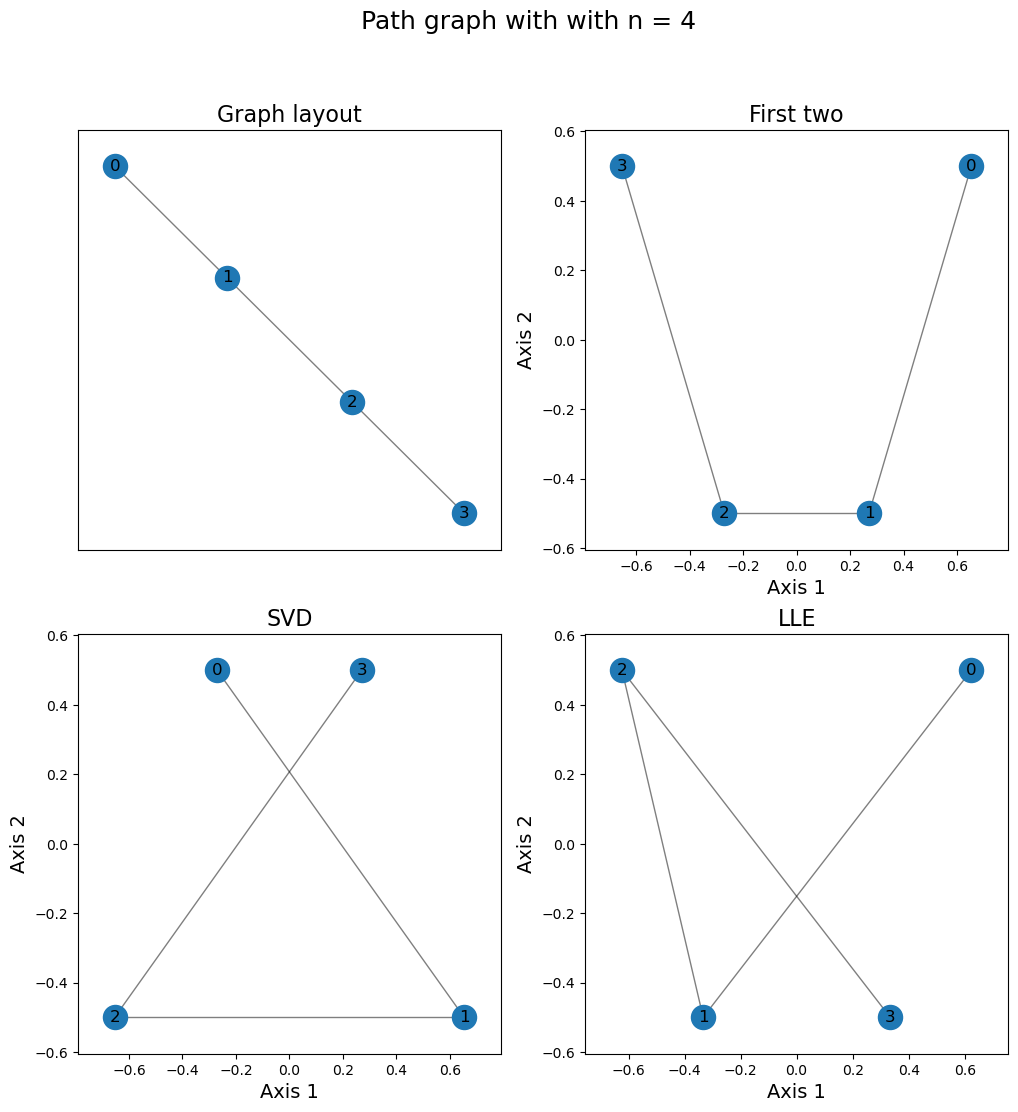

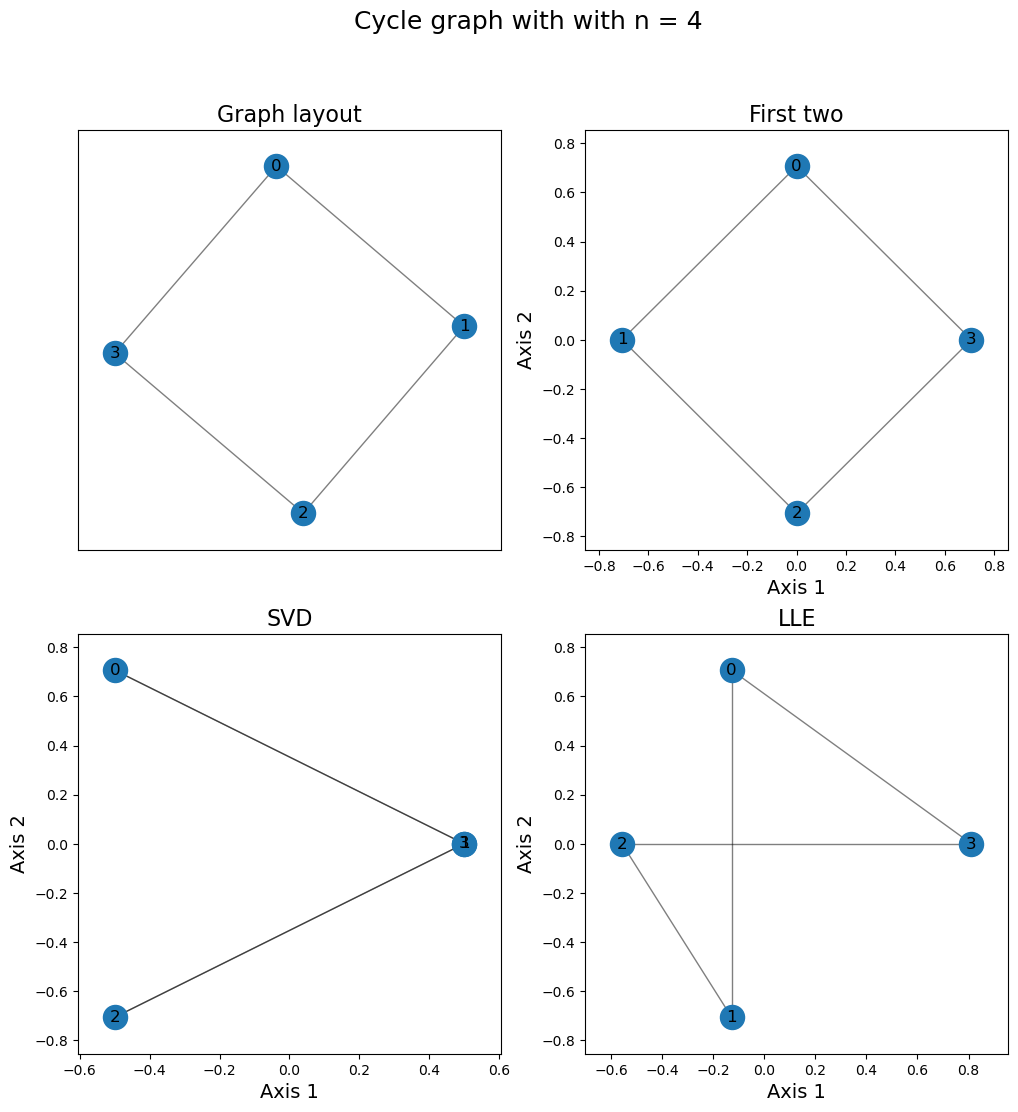

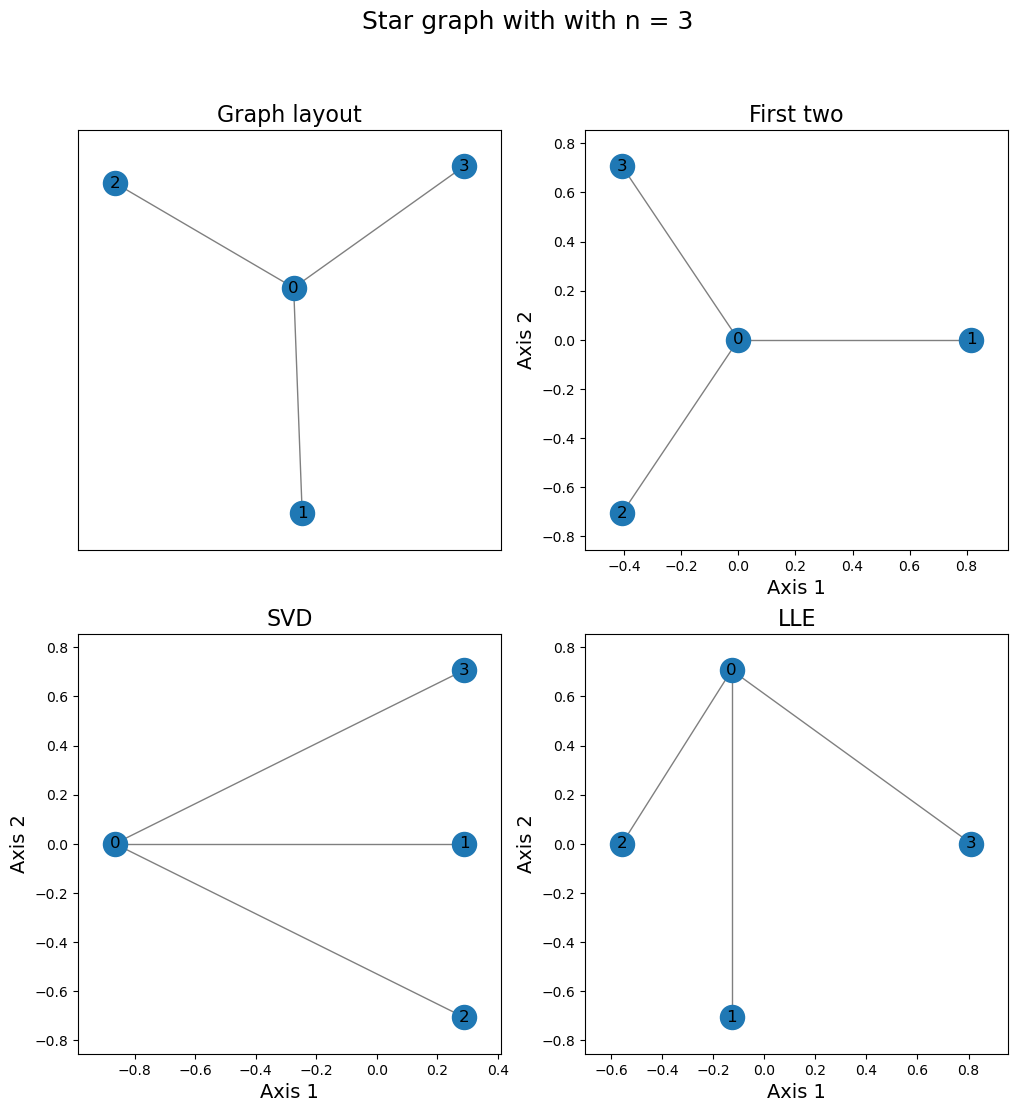

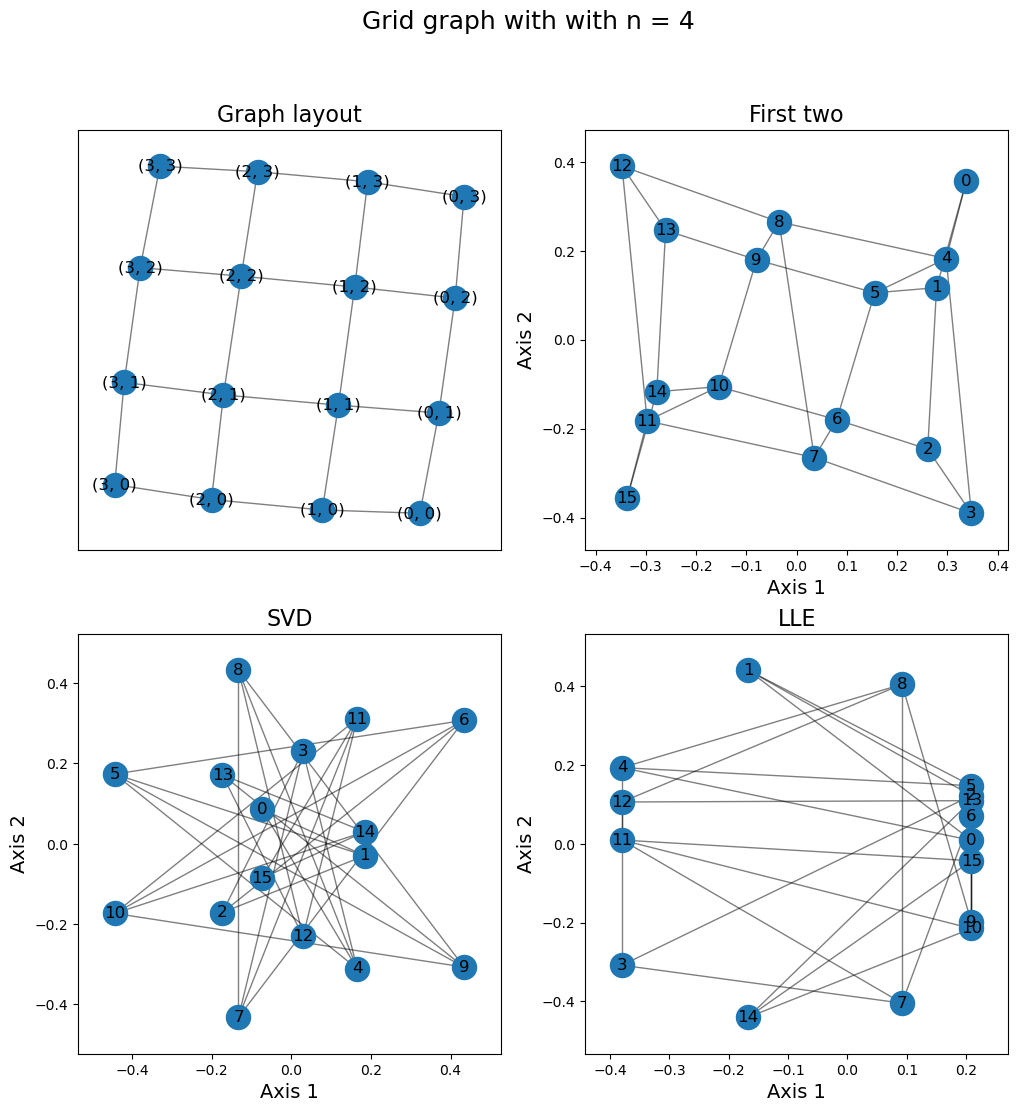

In [4]:
L_1 = np.array([[2, -1, -1],
                [-1, 2, -1],
                [-1, -1, 2]])
L_2 = generate_L_2(5)
L_3 = generate_L_3(4)
L_4 = generate_L_4(4)
L_5 = generate_L_5(4)
L_6 = generate_L_6(4)

L_list = [L_1, L_2, L_3, L_4, L_5, L_6]
plot_results(L_list, method="Graph Laplacian")

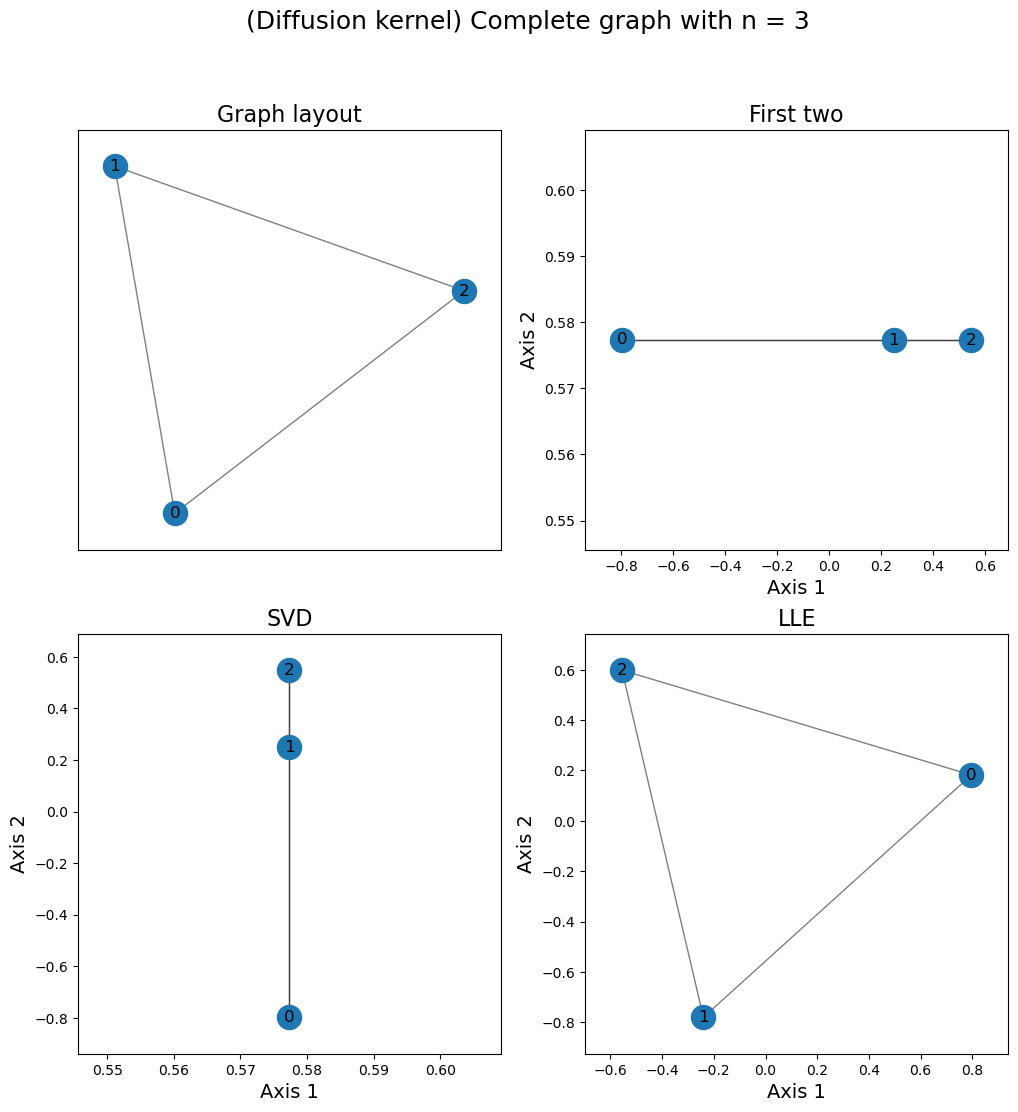

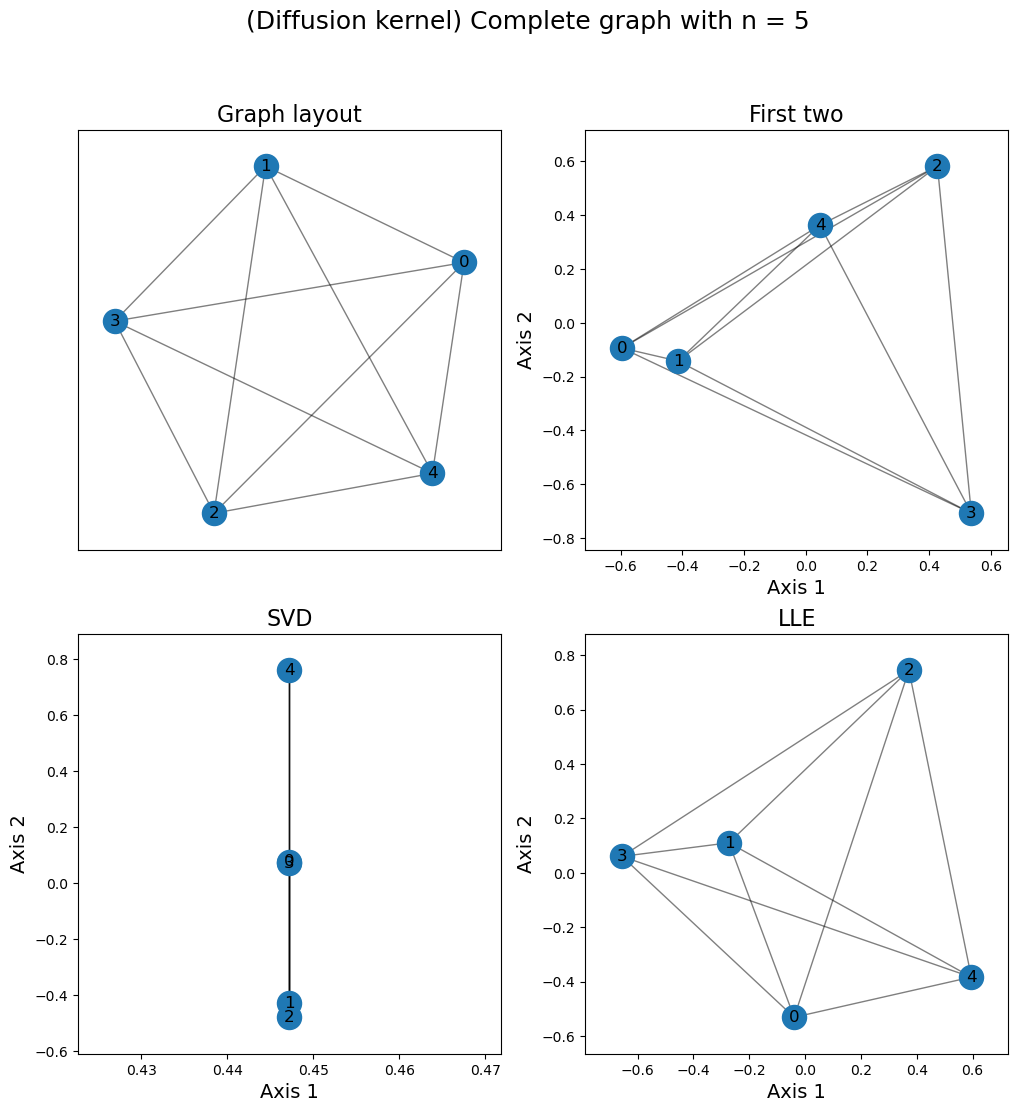

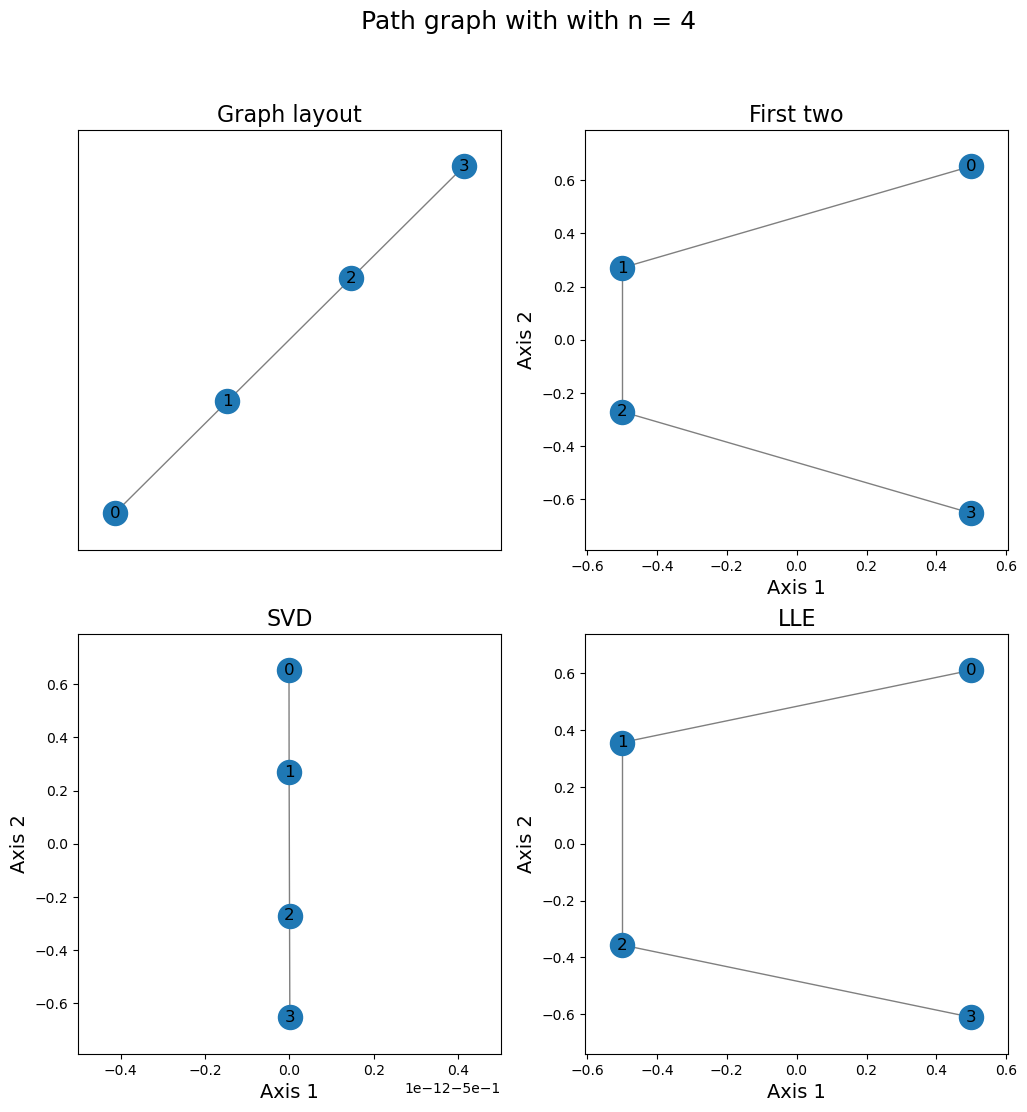

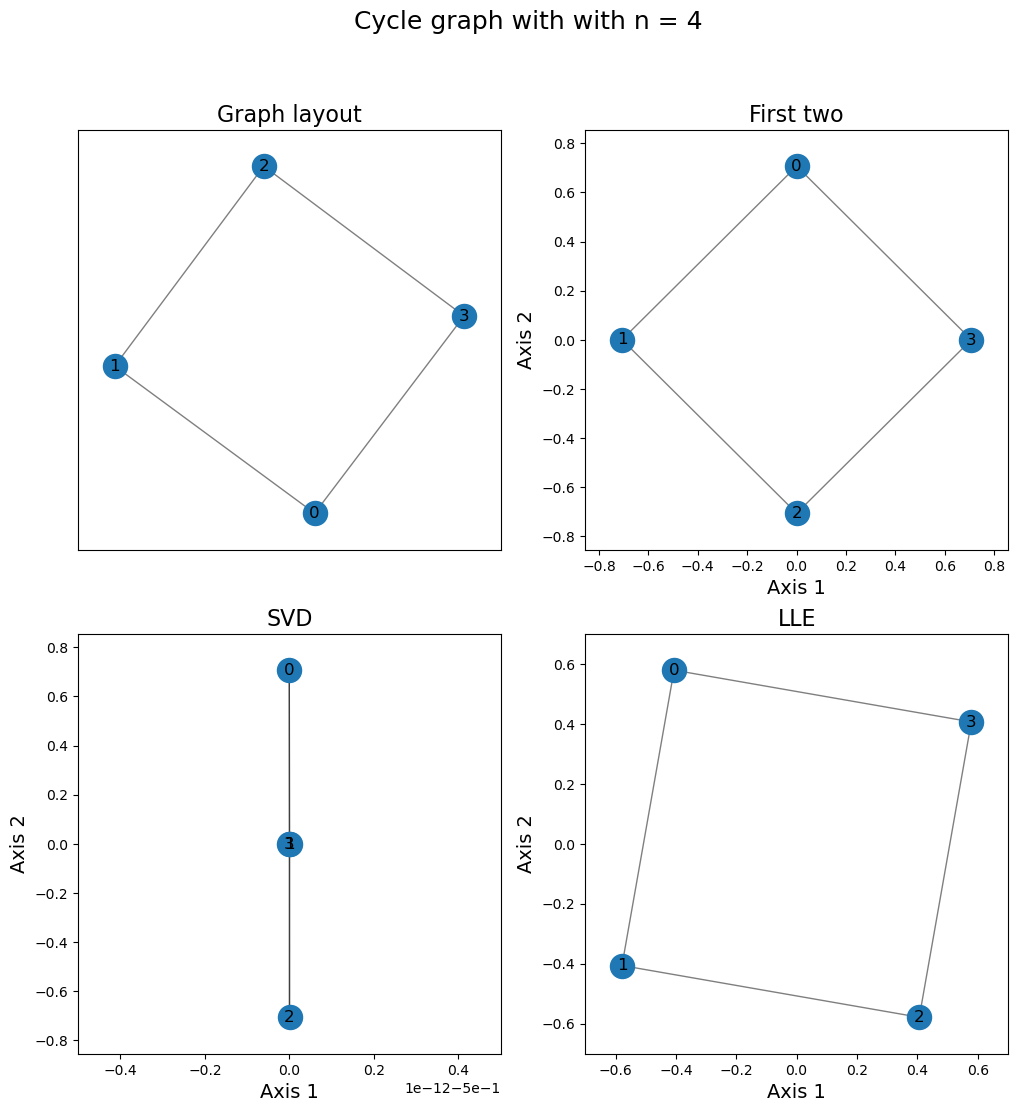

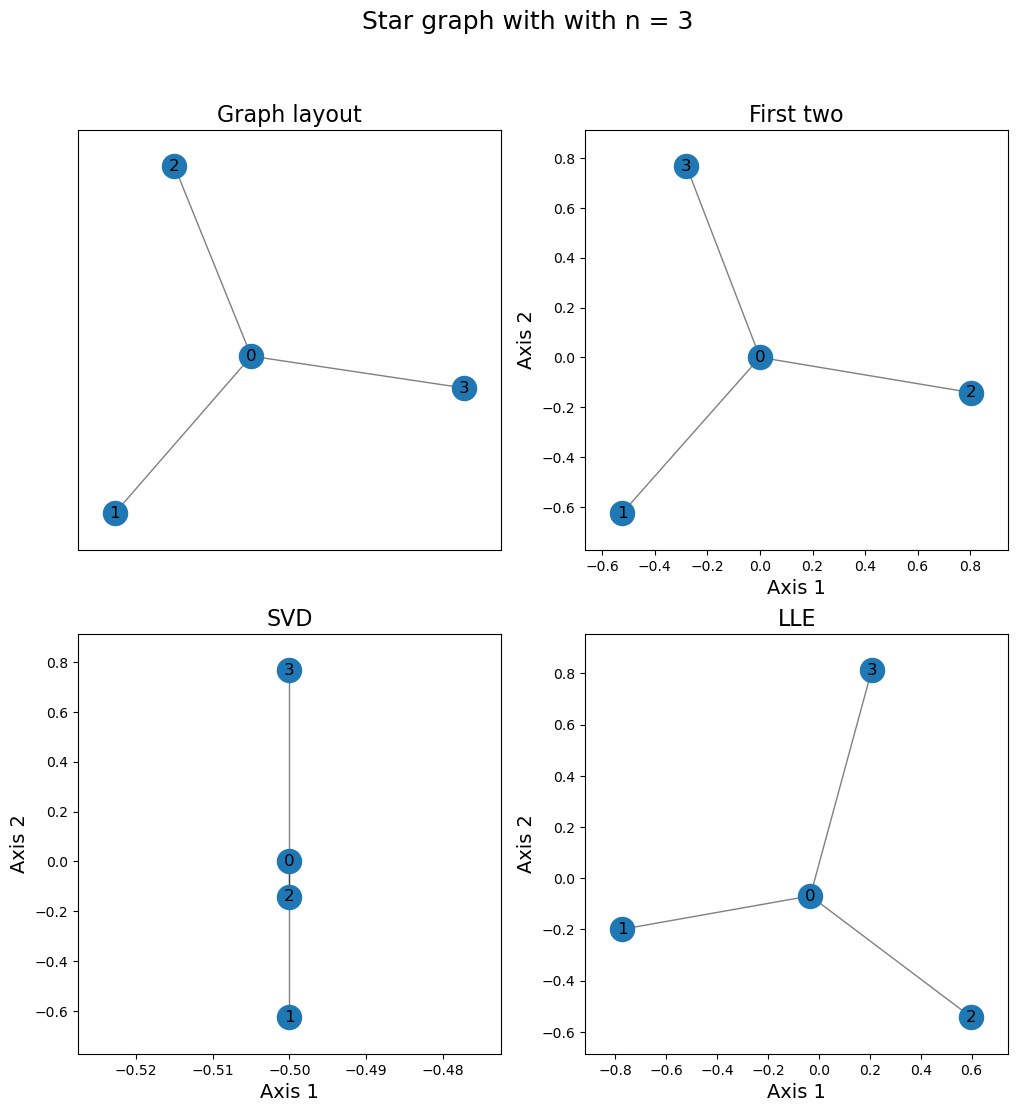

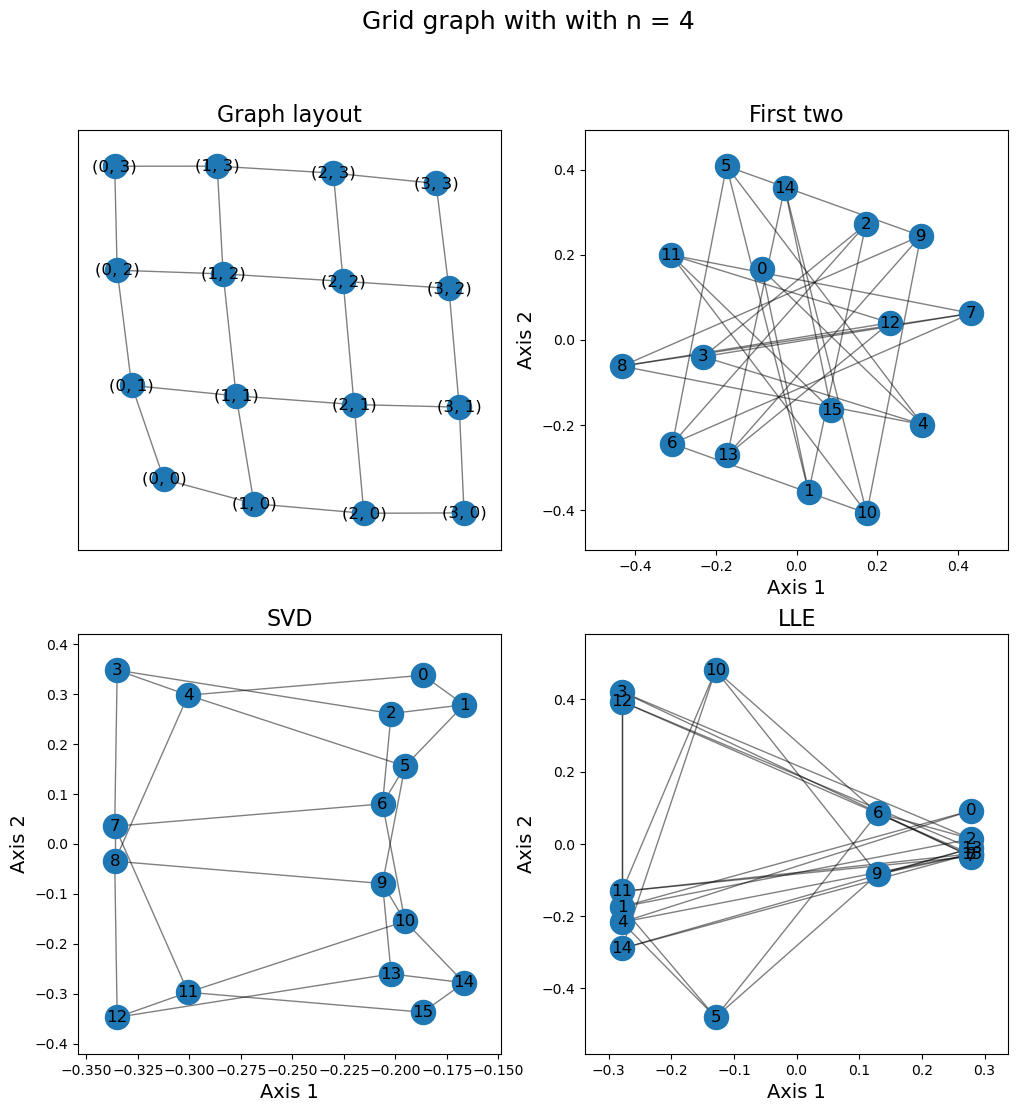

In [19]:
plot_results(L_list, method="Diffusion kernel", t=1)